In [ ]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)

  return PIL.Image.fromarray(tensor)

In [ ]:
path_1 = "/content/drive/MyDrive/ProjectII/Images/dog.jpg"
path_2 = "/content/drive/MyDrive/ProjectII/Images/starry-night.jpg"

In [ ]:
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, (422, 512))
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  plt.imshow(image)
  if title:
    plt.title(title)

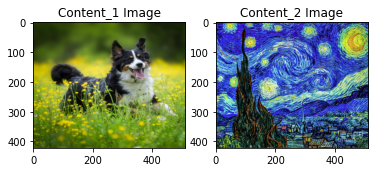

In [ ]:
content_1_image = load_img(path_1)
content_2_image = load_img(path_2)

plt.subplot(1, 2, 1)
imshow(content_1_image[0], 'Content_1 Image')

plt.subplot(1, 2, 2)
imshow(content_2_image[0], 'Content_2 Image')

In [ ]:
# Creates a vgg model that returns a list of intermediate output values 
def get_vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False,
                                    weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
# Create the model
content_layers = ['block5_conv1']
my_net = get_vgg_layers(content_layers)

def compute_feature(inputs):
  inputs = inputs*255.0
  preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
  content_outputs = my_net(preprocessed_input)

  return content_outputs

In [ ]:
my_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# Compute for target image 
content_target_1 = compute_feature(content_1_image)
content_target_2 = compute_feature(content_2_image)

(1, 422, 512, 3)


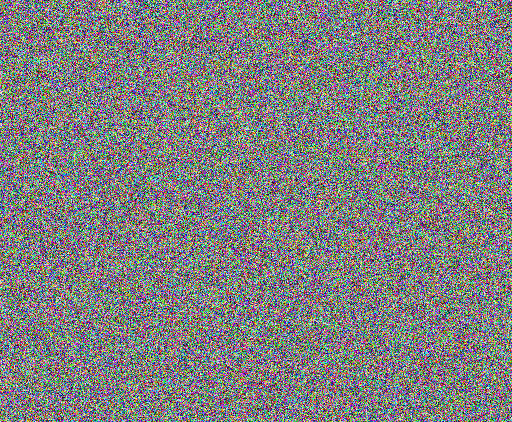

In [ ]:
# Init a variable image
image = tf.Variable(tf.random.uniform(content_1_image.shape,
                                      minval=0,
                                      maxval=1))

print(image.shape)

def clip_0_1(image):
  return tf.clip_by_value(image,
                          clip_value_min=0.0,
                          clip_value_max=1.0)
  
display.display(tensor_to_image(image[0]))

In [ ]:
# optimizer 
opt = tf.optimizers.Adam(learning_rate = 0.01,
                         beta_1=0.99,
                         epsilon=1e-1)

# content_loss
def content_loss(content_outputs):
  loss_1 = tf.reduce_mean((content_outputs - content_target_1)**2)
  loss_2 = tf.reduce_mean((content_outputs - content_target_2)**2)
  loss = loss_1 + loss_2
  return loss

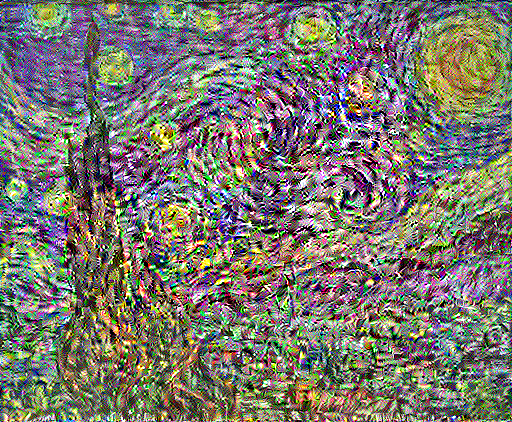

Train step: 9722


In [ ]:
epochs = 100
steps_per_epoch = 100

step = 0
for n in range (epochs):
  for m in range(steps_per_epoch):
    with tf.GradientTape() as tape:
      outputs = compute_feature(image)
      loss = content_loss(outputs)
    
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    display.clear_output(wait=True)
    display.display(tensor_to_image(image[0]))
    step = step + 1
    print("Train step: {}".format(step))